# Clustering Merch Data Shirts
1. remove texts that pop up in all documents (i.e. stopwords / phrases)
2. clean the documents
3. stem the words in each document

## Initialize steps

First we import the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

Import the stemmer and then tokenize and stem the text.

In [2]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if not re.search('[^a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if not re.search('[^a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens
print(tokenize_and_stem('artwork'))
# totalvocab_stemmed = []
# totalvocab_tokenized = []
# for i in documents:
#     allwords_stemmed = tokenize_and_stem(i)
#     totalvocab_stemmed.extend(allwords_stemmed)
    
#     allwords_tokenized = tokenize_only(i)
#     totalvocab_tokenized.extend(allwords_tokenized)
    
# vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

['artwork']


Now we import the shirt data file and create documents from it. Each document is the title of the shirt followed by it's description.

In [3]:
def clean_string(document):
    document = document.lower()
    default_1 = "Lightweight, Classic fit, Double-needle sleeve and bottom hem".lower()
    default_2 = "Solid colors: 100% Cotton; Heather Grey: 90% Cotton, 10% Polyester; All Other Heathers: 50% Cotton, 50% Polyester Imported Machine wash cold with like colors, dry low heat ".lower()
    document = document.replace(default_1, '').replace(default_2,'')
    
    document.replace("tee shirt","tshirt")
    document.replace("t-shirt", 'tshirt')
    document.replace(' t shirt', 'tshirt')
    document.replace("-", " ")
    
    document.replace("shirt", "")
    document.replace("tshirt", "")
    
    document.replace("officially licensed","")
    
    if re.compile("officially licensed [\w\s]+ (apparel|shirt)").search(document):
        document = re.sub(r'officially licensed [\w\s]+ (apparel|shirt)', '', document)
    
    if re.compile("official [\w\s]+merchandise").search(document):
        document = re.sub(r'official [\w\s]+merchandise', '', document)

    if re.compile("graphic [\w\s\-]+shirt").search(document):
        document = re.sub(r'graphic [\w\s\-]+shirt', '', document)
    
    
    document = BeautifulSoup(document, 'html.parser').getText()
    
    return document

def read_shirt_data_file(path):
    document_data = []
    with open(path, 'r') as data_file:
        for line in data_file:
            data = {}
            if len(line.replace("\"","").split('|')) == 11:
                for item in line.replace("\"","").split('|'):
                    data[item.split(':',1)[0]] = item.split(':',1)[1]
                data['document'] = clean_string(data['title'] + ". " + data['description'])
    #             line = line.split('|',10)
    #             new_line = []
    #             for item in line:
    #                 print(item)
    #                 new_line.append(item.split(':',1)[1])
    #             line = [item.split(':',1)[1] for item in line]
    #             line.append(clean_string(line[2] + ". " + line[10]))
                document_data.append(data)
    # [salesRank (0), asin(1), title(2), imageUrl(3), trademarked(4), isMerch(5), date(6), unix(7), errorMessage(8), link(9), description(10), document(11)]
    return document_data

document_data = read_shirt_data_file("shirts_featured1564783699")
print(document_data[0])

{'salesRank': '7681', 'asin': 'B07CZZJX5G', 'title': 'Beauty Has No Skin Tone - Melanin Slogan Unisex T-Shirt', 'imgUrl': 'https://m.media-amazon.com/images/I/A13usaonutL._CLa%7C2140,2000%7C71ssvjm33nL.png%7C0,0,2140,2000+0.0,0.0,2140.0,2000.0._UX522_.png', 'trademarked': 'False', 'isMerch': 'True', 'date': 'May 10, 2018', 'unix': '1525910400', 'errorMessage': '[]', 'link': 'https://www.amazon.com/dp/B07CZZJX5G', 'description': 'Solid colors: 100% Cotton; Heather Grey: 90% Cotton, 10% Polyester; All Other Heathers: 50% Cotton, 50% Polyester Imported Machine wash cold with like colors, dry low heat This Beauty Has No Skin Tone sassy attitude Tee Shirt makes a cool gift for all of the beautiful people in your life that represent independence, self-sureness and Black girl Magic. Perfect Novelty gift for both Men and Women. This inspirational quote slogan Tshirt features uplifting words to all from different Races and Skin color. A Funny Slogan T Shirt that makes a great gift for Christmas

Clean the documents to make them unicode.

In [88]:
# def clean_documents(documents):
#     documents_clean = []
#     for text in documents:
#         text = BeautifulSoup(text, 'html.parser').getText()
#         documents_clean.append(text)

#     return documents_clean

# documents = clean_documents(documents)

In [89]:
# print(documents)

## Option 1: 
cosine similarity of stems and ngrams (Tf-idf and document similarity)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

with open('stop_words.txt','r') as f:
    extra_stop_words = f.read().split('\n')

print(extra_stop_words)

my_stop_words = text.ENGLISH_STOP_WORDS.union(extra_stop_words)
#print(my_stop_words)

tfidf_vectorizer = TfidfVectorizer(max_df=0.15, max_features=200000,
                                 min_df=0, stop_words=my_stop_words,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform([document['document'] for document in document_data])
# print(tfidf_matrix)
# print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()
print(len(terms))
#print(stemmed_documents[99])

print(terms[247])

from sklearn.metrics.pairwise import cosine_similarity
#print(cosine_similarity(tfidf_matrix))
# print(tfidf_matrix[0])
# print(tfidf_matrix[1])
# print(tfidf_matrix[2])
start = 0
length = 1
dist = cosine_similarity(tfidf_matrix[start:start+length],tfidf_matrix)
print(dist)
for doc_vector_index, doc_vector in enumerate(dist):
    print("checking {} for similarities...".format(document_data[start + doc_vector_index]['asin']))
    print("{}".format(document_data[start + doc_vector_index]['document']))
    for similarity_index, doc_similarity in enumerate(doc_vector):
        if doc_similarity > .1:
            print("{} {}".format(doc_similarity, document_data[similarity_index]['document']))
        
    
# print(tfidf_matrix.shape)
# print(dist)

['logo', 'shirt', 'tshirt', 'vintage', 'movie', 'officially', 'licensed', 'official', 'offici', 'licens', 'graphic', 'artwork']


/usr/local/anaconda3/envs/niche_finder/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'licen', 'mani', 'meanwhil', 'moreov', 'movi', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'vintag', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsi

CPU times: user 1.56 s, sys: 7.24 ms, total: 1.57 s
Wall time: 1.56 s
41598
adult gift idea
[[1.00000000e+00 0.00000000e+00 9.47464803e-03 0.00000000e+00
  0.00000000e+00 4.06166932e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.90944530e-03 2.49688874e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.95491411e-03 1.24636726e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.55230879e-03
  4.35015279e-03 2.17363267e-02 2.70100062e-03 1.96432015e-03
  1.17448022e-02 0.00000000e+00 0.00000000e+00 1.21825052e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.14083546e-03 2.00966719e-03 1.08051697e-02 8.62367795e-03
  0.00000000e+00 4.47424149e-03 3.79460966e-03 0.00000000e+00
  3.83803548e-03 2.60618835e-03 0.00000000e+00 0.00000000e+00
  3.00832919e-03 6.64150691e-03 0.00000000e+00 1.48329183e-03
  0.00000000e+00 2.09831929e-02 0.00000000e+00 2.57153138e-03
  6.55392705e-03 0.00000000e+00 0.000000

## Option 2: 
soft cosine similarity using fasttext similarity matrix of single tokens (not good for mba because the exact text needs to be the same)

In [6]:
import gensim
# upgrade gensim if you can't import softcossim
from gensim.matutils import softcossim 
from gensim import corpora
import gensim.downloader as api
from gensim.utils import simple_preprocess # all this does is split a string into an array and clean out punctuation
print(gensim.__version__)
#> '3.6.0'

# Download the FastText model
og_fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')
print("done")

3.4.0
done


In [36]:
print(documents[0])
stemmed_documents = [tokenize_and_stem(document) for document in documents ]
print(stemmed_documents[0])

# simple_preprocess

# Prepare a dictionary and a corpus.
dictionary = corpora.Dictionary(stemmed_documents) # should be using just documents
print(dictionary)
# Prepare the similarity matrix
similarity_matrix = fasttext_model300.similarity_matrix(dictionary, tfidf=None, threshold=0.0, exponent=2.0, nonzero_limit=100)
print(similarity_matrix)
# Convert the sentences into bag-of-words vectors.
sent_1 = dictionary.doc2bow(simple_preprocess(documents[0]))
print(sent_1)

Dictionary(844 unique tokens: ['aveng', 'endgam', 'graphic', 'licens', 'logo']...)
  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (87, 2)	0.29002804
  (513, 2)	0.39525434
  (3, 3)	1.0
  (4, 4)	1.0
  (364, 4)	0.3381835
  (367, 4)	0.30361277
  (421, 4)	0.3721742
  (422, 4)	0.2973664
  (476, 4)	0.53717667
  (511, 4)	0.38052085
  (575, 4)	0.36415815
  (620, 4)	0.31270242
  (76, 4)	0.24808821
  (5, 5)	1.0
  (137, 5)	0.353291
  (734, 5)	0.24536575
  (6, 6)	1.0
  (7, 7)	1.0
  (8, 8)	1.0
  (43, 8)	0.549481
  (180, 8)	0.39647278
  (197, 8)	0.36107263
  :	:
  (270, 833)	0.3811983
  (381, 833)	0.37798473
  (834, 834)	1.0
  (835, 835)	1.0
  (836, 836)	1.0
  (38, 836)	0.3020304
  (56, 836)	0.3202309
  (64, 836)	0.4149798
  (343, 836)	0.5361713
  (414, 836)	0.8350328
  (568, 836)	0.33491045
  (645, 836)	0.6516957
  (697, 836)	0.34693995
  (768, 836)	0.566946
  (837, 837)	1.0
  (410, 837)	0.20215365
  (622, 837)	0.4176403
  (838, 838)	1.0
  (839, 839)	1.0
  (840, 840)	1.0
  (560, 840)	0.4419296
  (841, 841

In [37]:
print(dictionary.token2id)

{'aveng': 0, 'endgam': 1, 'graphic': 2, 'licens': 3, 'logo': 4, 'marvel': 5, 'movi': 6, 'offici': 7, 'shirt': 8, 'tee': 9, 'a': 10, 'are': 11, 'as': 12, 'be': 13, 'fan': 14, 'list': 15, 'more': 16, 'releas': 17, 'studio': 18, 'than': 19, 'this': 20, 'updat': 21, 'will': 22, 'autism': 23, 'autist': 24, 'awar': 25, 'behavior': 26, 'disord': 27, 'for': 28, 'heart': 29, 'is': 30, 'kid': 31, 'kind': 32, 'love': 33, 'month': 34, 'or': 35, 'perfect': 36, 'puzzl': 37, 'ribbon': 38, 'show': 39, 'spectrum': 40, 'the': 41, 'to': 42, 'tshirt': 43, 'with': 44, 'art': 45, 'by': 46, 'dawson': 47, 'design': 48, 'god': 49, 'gsm': 50, 'my': 51, 'oh': 52, 'pig': 53, 'shane': 54, 'infin': 55, 'neon': 56, 'team': 57, 'war': 58, 'about': 59, 'adult': 60, 'aur': 61, 'book': 62, 'children': 63, 'color': 64, 'dad': 65, 'gift': 66, 'girl': 67, 'hand': 68, 'i': 69, 'mom': 70, 'piec': 71, 'product': 72, 'ring': 73, 'see': 74, 'speak': 75, 'sticker': 76, 't': 77, 'toddler': 78, 'toy': 79, 'true': 80, 'your': 81, '

In [53]:
print(similarity_matrix[7])

  (0, 7)	1.0


In [ ]:
sent_1 = dictionary.doc2bow(simple_preprocess(documents[0]))
print(sent_1)
sent_2 = dictionary.doc2bow(simple_preprocess(documents[16]))
print(documents[0])
print(documents[18])
print(softcossim(sent_1, sent_2, similarity_matrix))

## K-means clustering

K-means isn't necessarily the best. You must initialize with a pre-determined number of clusters

In [ ]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

## Hierarchial document clustering

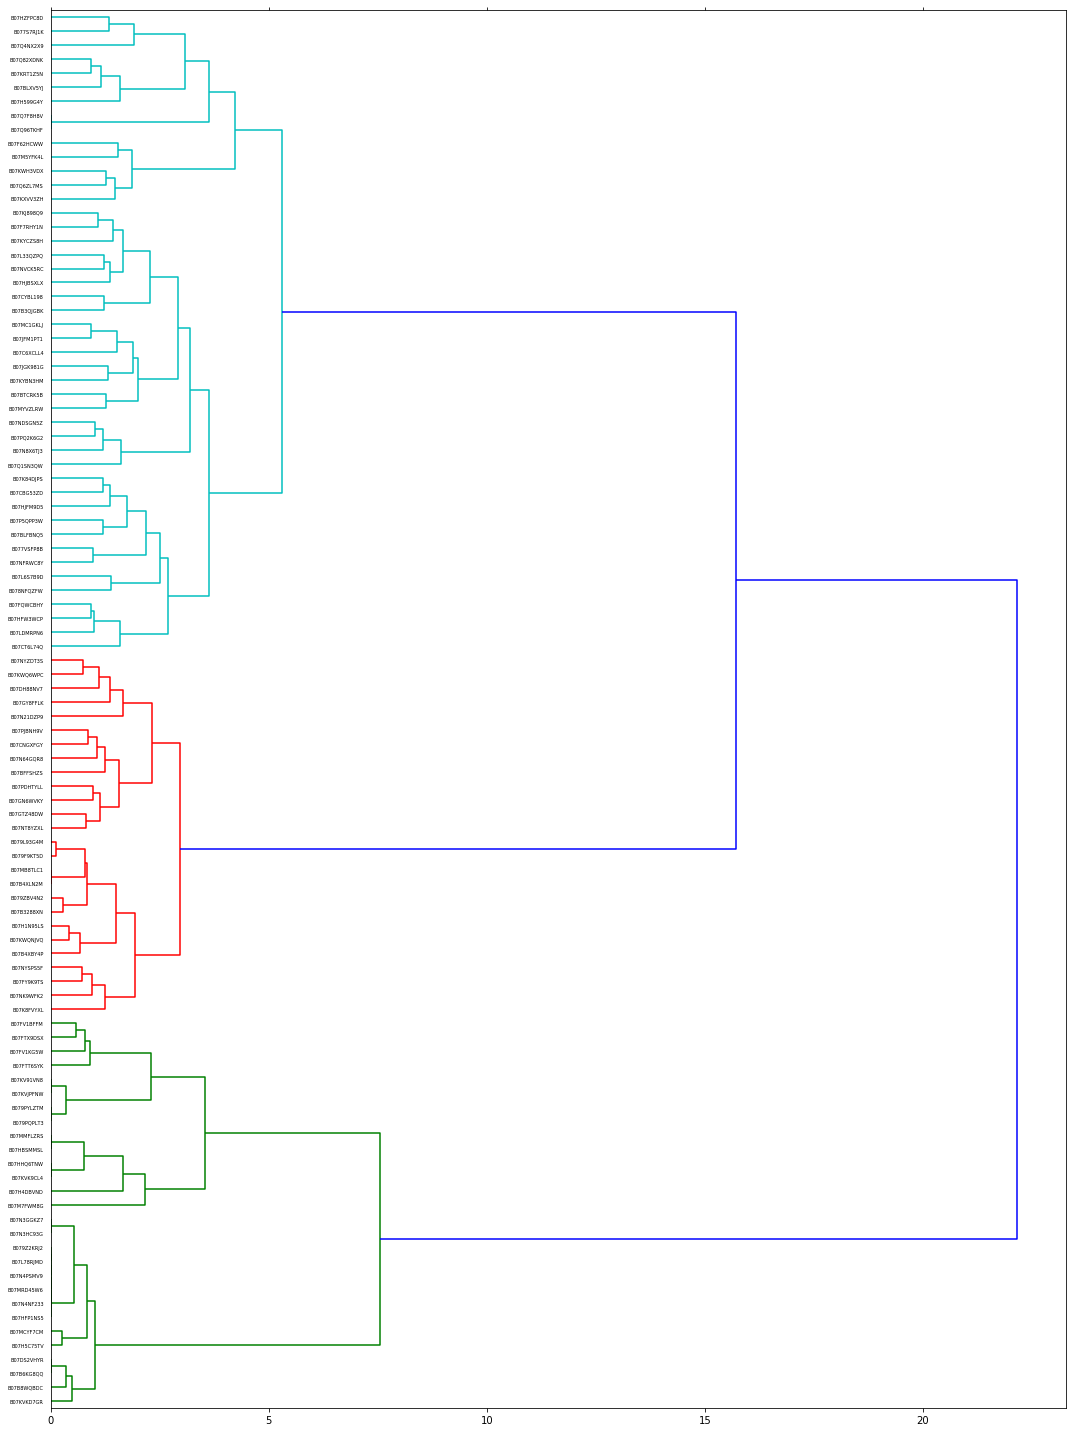

In [33]:
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt


linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=asins);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters